In [12]:
import pickle as pkl
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)
import bvcopula
from vine import CVine


i=1
with open(f'/home/nina/CopulaGP/trained_models/ST260_Day1_Dataset_trained.pkl',"rb") as f:
    trained_all = pkl.load(f)

with open(f'/home/nina/CopulaGP/trained_models/ST260_Day1_Dataset_G_trained.pkl',"rb") as f:
    trained_gauss = pkl.load(f)

device = 'cuda:0'

In [19]:
# calculate H(y,v|x)

N_points = 200
inputs = torch.linspace(0,1,N_points,device=device).float()

trained= trained_all

Hs = []

for reps in tqdm(range(10)):
    %time vine = CVine.marginalize(trained['models'],inputs)
    sem_tol = 0.1
    %time H20 = vine.entropy(sem_tol=sem_tol,mc_size=2000,v=True).cpu().numpy()

    Hs.append([H20])

CPU times: user 18.3 s, sys: 48 ms, total: 18.4 s
Wall time: 18.4 s
tensor(1.7582, device='cuda:0')
tensor(1.2440, device='cuda:0')
tensor(1.0136, device='cuda:0')
CPU times: user 4min 19s, sys: 166 ms, total: 4min 20s
Wall time: 3min 2s
CPU times: user 18.1 s, sys: 64 ms, total: 18.1 s
Wall time: 18.1 s
tensor(1.7848, device='cuda:0')
tensor(1.2324, device='cuda:0')
tensor(1.0093, device='cuda:0')
CPU times: user 4min 20s, sys: 176 ms, total: 4min 20s
Wall time: 3min 2s
CPU times: user 18 s, sys: 96 ms, total: 18.1 s
Wall time: 18.1 s
tensor(1.7521, device='cuda:0')
tensor(1.2340, device='cuda:0')
tensor(1.0108, device='cuda:0')
CPU times: user 4min 21s, sys: 322 ms, total: 4min 21s
Wall time: 3min 3s
CPU times: user 18.4 s, sys: 92 ms, total: 18.5 s
Wall time: 18.5 s
tensor(1.7885, device='cuda:0')
tensor(1.2515, device='cuda:0')
tensor(1.0170, device='cuda:0')
CPU times: user 4min 29s, sys: 268 ms, total: 4min 29s
Wall time: 3min 8s
CPU times: user 17.8 s, sys: 92 ms, total: 17.9 s


In [ ]:
for h in Hs:
    plt.plot(h[0])

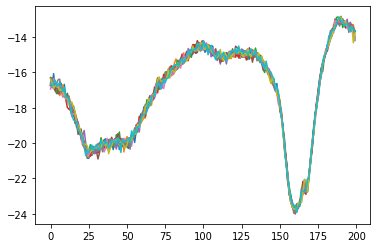

In [8]:
for h in Hs:
    plt.plot(h[0])

In [ ]:
with open(f"{home}/results_redo/HYgX_109V_all.pkl","wb") as f:
    pkl.dump([20,inputs.cpu().numpy(),Hs],f)

In [9]:
# calculate I(u^x,x)
MIs = []

for trained in [trained_gauss]: #day-1

    sem_tol = 0.1
    %time vine = CVine.marginalize(trained['models'],torch.tensor(trained['X'],device=device).float())
    %time MI = vine.truncate(19).inputMI(sem_tol=sem_tol, s_mc_size=50, r_mc_size=20, sR_mc_size=1000, v=True)
    
    MIs.append(MI)

CPU times: user 37.5 s, sys: 104 ms, total: 37.6 s
Wall time: 37.5 s
Start calculating p(r) 0
Finished in 5 steps
15.0,12.8,2.14,                        5.62,5.15
Start calculating p(r) 1
Finished in 5 steps
15.5,13.5,2.04,                        4.16,3.81
Start calculating p(r) 2
Finished in 9 steps
15.5,13.3,2.16,                        3.38,3.06
Start calculating p(r) 3
Finished in 6 steps
15.6,13.4,2.15,                        2.91,2.64
Start calculating p(r) 4
Finished in 3 steps
15.7,13.5,2.12,                        2.61,2.36
Start calculating p(r) 5
Finished in 2 steps
15.7,13.6,2.11,                        2.38,2.16
Start calculating p(r) 6
Finished in 4 steps
15.7,13.6,2.1,                        2.19,1.99
Start calculating p(r) 7
Finished in 5 steps
15.6,13.5,2.08,                        2.04,1.86
Start calculating p(r) 8
Finished in 4 steps
15.6,13.6,2.08,                        1.94,1.76
Start calculating p(r) 9
Finished in 3 steps
15.8,13.7,2.08,                        1.